# Backtesting the AI Investor
Chapter 5 of the book: "Build Your Own AI Investor"

In [1]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [2]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [3]:
from platform import python_version
print(python_version())

3.7.10


In [4]:
def loadXandyAgain(randRows=False):
    '''
    Load X and y.
    Randomises rows.
    Returns X, y.
    '''
    # Read in data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv",
                  index_col=0)
    y=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv",
                  index_col=0)
    y=y["Perf"] # We only need the % returns as target
    
    if randRows:
        # randomize the rows
        X['y'] = y
        X = X.sample(frac=1.0, random_state=42) # randomize the rows
        y = X['y']
        X.drop(columns=['y'], inplace=True)

    return X, y

# Train a model from here for backtest
Otherwise train a model in previous notebook, where data will be loaded into this notebook.

We select stocks in a backtest with a picked, pretrained model.

The the train set trains the mdoel the test set is sent to the backtester.

In [5]:
X, y = loadXandyAgain()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=42)

# Save CSVs 
# For the backtester to get correct test data
# in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import pickle # To save the fitted model

pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
    ('linear', LinearRegression())]).fit(X_train, y_train)

y_pred = pl_linear.predict(X_test)

print('train mse: ', 
      mean_squared_error(y_train, pl_linear.predict(X_train)))
print('test mse: ',
      mean_squared_error(y_test, y_pred))

pickle.dump(pl_linear, open("pl_linear.p", "wb" ))

train mse:  0.3668897622925844
test mse:  462.67364066367236


Or can use Random Forest

In [5]:
X, y = loadXandyAgain()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Save CSVs 
# For the backtester to get correct test data
# in case want to see the data.
X_train.to_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv")
X_test.to_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv")
y_train.to_csv("Annual_Stock_Price_Performance_Percentage_train.csv")
y_test.to_csv("Annual_Stock_Price_Performance_Percentage_test.csv")

# Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfregressor = RandomForestRegressor(random_state=42, max_depth=10).fit(X_train, y_train)

y_pred = rfregressor.predict(X_test)

print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))
import pickle # To save the fitted model
pickle.dump(rfregressor, open("rfregressor.p", "wb" ))

train mse:  0.18265051393714118
test mse:  0.41388505668509756


# Read in Train/Test

In [6]:
# X AND Y
# The backtester needs dates from the old y vector 
# to plot the stock prices.

# Financial ratios 
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
              index_col=0)

# Annual stock performances, with date data.
y_withData=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", 
                       index_col=0)

# Convert to date
y_withData["Date"] = pd.to_datetime(y_withData["Date"])
y_withData["Date2"] = pd.to_datetime(y_withData["Date2"])

# X AND Y (splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", 
                    index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", 
                   index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", 
                    index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", 
                   index_col=0)

# Get y_withData to correspond to y_test
y_withData_Test=pd.DataFrame()
y_withData_Test=y_withData.loc[y_test.index, :]

# Convert string to datetime
y_withData_Test["Date"] = pd.to_datetime(y_withData_Test["Date"])
y_withData_Test["Date2"] = pd.to_datetime(y_withData_Test["Date2"])

In [7]:
y_test.head() # y targets

,Perf
7217,0.616757
12508,0.184577
14996,0.524234
5852,0.153191
8857,0.039030


In [8]:
y_withData_Test.head() # y data corresponding to y targets

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
7217,INTC,12.89,2009-02-23,1.139689e+09,INTC,20.84,2010-02-23,1.297192e+09
12508,SIX,40.20,2014-02-20,5.493330e+07,SIX,47.62,2015-02-20,9.688984e+07
14996,WHR,139.06,2014-02-18,1.992591e+08,WHR,211.96,2015-02-18,1.579801e+08
5852,FUEL,2.35,2016-06-21,5.085330e+05,FUEL,2.71,2017-06-21,7.417731e+05
8857,MCHP,47.40,2014-05-30,4.534758e+07,MCHP,49.25,2015-06-01,7.098634e+07


# Z score to account for default chance

In [9]:
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

In [10]:
z = calcZScores(X)
z.head()

,Z score
0,7.664439
1,7.435224
2,7.538172
3,9.311402
4,8.385200


# Backtest Program

In [11]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData(directory='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

In [12]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [13]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
#     # Alternative way
#     rows = d[(d["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (d["Ticker"]==ticker)]
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [14]:
def getStockPriceData(ticker, y_withData, mask, daily_stock_prices, rows):
    '''
    Get the stock price for a ticker
    between the buy/sell date (using y_withdata)
    '''
    date1 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [15]:
def getDataForDateRange(date_Index_New, rows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")])
    return WeeklyStockDataRows

In [16]:
def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, mask, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame
    for a list of tickers.
    A mask is used to only consider stocks for a certain period.
    dateTimeIndex is typically a weekly index,
    so we know what days to fetch the price for.
    '''
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows = pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data 
        # for individual stock
        rows = getStockPriceData(tick, 
                                 y_withData, 
                                 mask, 
                                 daily_stock_prices, 
                                 rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new,
                                                  rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick] = WeeklyStockDataRows["Close"].values
    return stockRet

In [17]:
def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [47]:
### First tutorial function reader will write for backtest, will add altmanZ score filter later in chapter. ###
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for 
    all stocks
    '''
    
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
            pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
            pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    # Bool list of top stocks
    bl_bestStocks=(y_pred[0]>y_pred.nlargest(8,0).tail(1)[0].values[0]) 
    
    # DatetimeIndex
    dateTimeIndex = pd.date_range(\
                        start=date_starting, periods=52, freq='W')
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = y[thisYearMask].reset_index(drop=True)\
                  [bl_bestStocks]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))

    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData, 
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 
    # 1st day(or close) and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [19]:
### Proper function ###
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # get y dataframe with ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
      
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(X)
    
    # 3.75 is approx. B- rating
    bl_safeStocks=(z['Z score'][thisYearMask].reset_index(drop=True)>2) 
    y_pred_z = y_pred[bl_safeStocks]
    
    # Get bool list of top stocks
    bl_bestStocks=(
        y_pred_z[0]>y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl_bestStocks & bl_safeStocks]) 
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[thisYearMask].reset_index(drop=True)\
                      [bl_bestStocks&bl_safeStocks]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
    '''
    ##### Tutorial code without Z score filtering ##### 
    # bool list of top stocks
    bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0]) 
    # DatetimeIndex
    dateTimeIndex = pd.date_range(start=date_starting, periods=52, freq='W')
    # 7 greatest performance stocks of y_pred 
    ticker_list = y[thisYearMask].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
    ##### Tutorial code without Z score filtering ##### 
    '''
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData,
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [20]:
def getPortTimeSeries(y_withData, X, daily_stock_prices, 
                      ml_model_pipeline, verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 
    2009. Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    dr=pd.date_range(start='2009-01-01', periods=11, freq='Y') 
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_withData, X,\
                                 daily_stock_prices, ml_model_pipeline)
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Run a Backtest

In [21]:
daily_stock_prices_data=getYRawData()

Reading historical time series stock data, matrix size is:  (6482905, 11)


In [48]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
trained_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))
#trained_model_pipeline = pickle.load(open("rfregressor.p", "rb" ))

backTest = getPortTimeSeries(y_withData_Test, X_test, 
                         daily_stock_prices_data, 
                         trained_model_pipeline)
print('Performance is: ', 
      100 * (backTest["Indexed Performance"][-1]-1), 
      '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 21.95 %
With stocks: ['ALNY' 'SBH' 'GRA' 'EV' 'TMUS' 'WEN' 'SBAC']
ALNY Performance was: -42.39 %
SBH Performance was: 57.52 %
GRA Performance was: 23.31 %
EV Performance was: 1.98 %
TMUS Performance was: 102.73 %
WEN Performance was: -3.55 %
SBAC Performance was: 14.09 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: 0.05 %
With stocks: ['REV' 'INVA' 'PCRX' 'AAL' 'KATE' 'AXL' 'RGC']
REV Performance was: 0.96 %
INVA Performance was: -1.77 %
PCRX Performance was: 25.18 %
AAL Performance was: -45.56 %
KATE Performance was: 68.94 %
AXL Performance was: -29.93 %
RGC Performance was: -17.49 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: -12.05 %
With stocks: ['NURO' 'DPZ' 'NCMI' 'MTOR' 'NAV' 'CALL' 'CBB']
NURO Performance was: -40.52 %
DPZ Performance was: 11.08 %
NCMI Performance was: -6.83 %
MTOR 

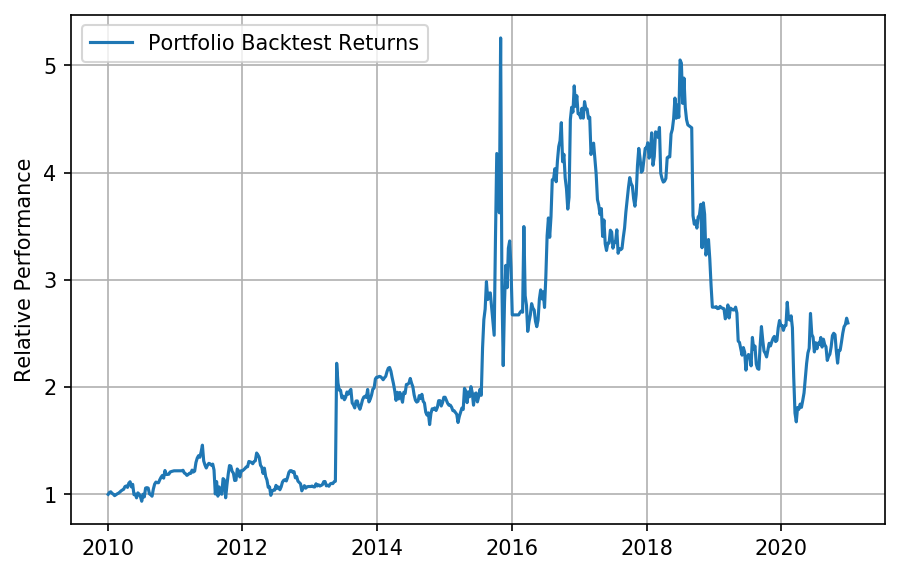

In [49]:
plt.plot(backTest)
plt.grid()
plt.legend(['Portfolio Backtest Returns'])
plt.ylabel('Relative Performance');

# Investigating The Results

In [50]:
y_small=getYPerf(y_withData_Test)
# y_small is cut down version of y with stock returns only

# Create a boolean mask for the backtest year we are interested in
myDate = pd.to_datetime('2017-12-31')
mask2015 = y_withData_Test["Date"].between(pd.to_datetime(myDate)
                                           -pd.Timedelta(days=60),
                                           pd.to_datetime(myDate)
                                           +pd.Timedelta(days=60))

y_withData_Test[mask2015] # Checking the mask works

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
13765,TPX,12.38,2018-03-01,1.499216e+07,TPX,14.72,2019-03-01,8.033646e+06
2231,BRO,26.68,2018-02-28,1.632752e+07,BRO,29.38,2019-02-28,3.356891e+07
15267,WWE,35.13,2018-02-08,7.087934e+07,WWE,82.43,2019-02-08,8.959910e+07
15393,XOM,78.16,2018-02-28,1.286009e+09,XOM,79.45,2019-02-28,1.159802e+09
2009,BLD,72.42,2018-02-27,5.172664e+07,BLD,59.92,2019-02-27,1.951361e+07
...,...,...,...,...,...,...,...,...
12633,SMG,97.86,2017-11-28,2.241640e+07,SMG,74.02,2018-11-28,2.556022e+07
3395,COO,221.25,2017-12-22,4.856438e+07,COO,235.93,2018-12-24,8.423385e+07
6946,IAC,48.76,2018-03-01,4.941451e+07,IAC,69.97,2019-03-01,4.112515e+07
10609,OXFD,11.90,2018-02-27,2.397910e+06,OXFD,16.56,2019-02-27,2.672569e+06


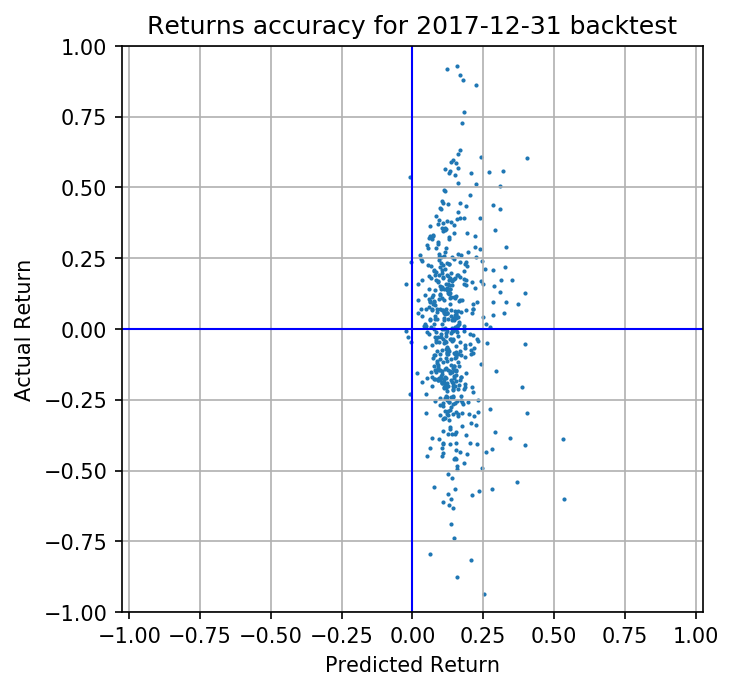

In [51]:
# Load the model pipeline
ml_model_pipeline = pickle.load(open("pl_linear.p", "rb" ))

# Get stock performance predictions
y_pred = ml_model_pipeline.predict(X_test[mask2015]) 
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame


# Now output scatter graph to see prediction/actual
# for that year only.
plt.figure(figsize=(5,5))
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
plt.scatter(y_pred[0], y_small[mask2015]["Perf"], s=1)
# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {}-{}-{} backtest'.format(myDate.year, myDate.month, myDate.day))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [55]:
# Top stocks picked, and predicted performance.
bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked and predicted performance is:")
print(y_small[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"])
print(y_pred[bl_bestStocks])

print("\nActual performance was: ")
print(y_small[mask2015].reset_index(drop=True)[bl_bestStocks])

'''# Calc Altman Z score.
# To check if these companies were going to go bankrupt
Z = 3.25 \
+ 6.51 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['(CA-CL)/TA']\
+ 3.26 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['RE/TA']\
+ 6.72 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['EBIT/TA']\
+ 1.05 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['Book Equity/TL']
print('\nZ scores:\n',Z)''';


Top predicted perf. stocks picked and predicted performance is:
44     VTVT
180     LEE
257    WNDW
269    SGMS
341     DIN
377     NAV
473    EGAN
Name: Ticker, dtype: object
            0
44   0.534452
180  0.399055
257  0.532018
269  0.405163
341  0.403704
377  0.397023
473  0.398858

Actual performance was: 
    Ticker      Perf
44    VTVT -0.599374
180    LEE -0.052174
257   WNDW -0.386965
269   SGMS -0.296420
341    DIN  0.605108
377    NAV -0.408809
473   EGAN  0.125424


In [56]:
# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask2015]["Perf"].reset_index(drop=True)[bl_bestStocks].values.mean())

Backtest return is:
-0.14474432575296767


In [40]:
#daily_stock_prices_data = getYRawData()

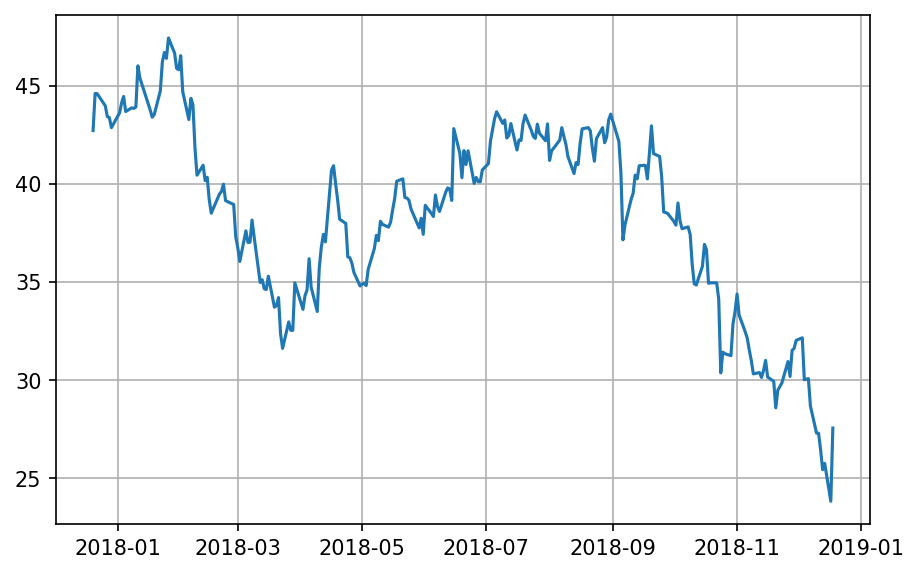

In [57]:
# Look at stock price of one of the companies
rows = getStockPriceData("NAV", 
                         y_withData_Test, 
                         mask2015, 
                         daily_stock_prices_data, 
                         rows=pd.DataFrame())

plt.plot(rows["Date"], rows["Close"]) # Adj. Close
plt.grid(True)

In [63]:
rows

,Ticker,SimFinId,Date,Open,Low,High,Close,Adj. Close,Dividend,Volume,Shares Outstanding
4675436,BXC,673388,2015-02-23,11.60,10.90,11.70,10.90,10.90,NaN,3160,8941624.0
4675437,BXC,673388,2015-02-24,10.80,10.20,11.10,11.00,11.00,NaN,15227,8941624.0
4675438,BXC,673388,2015-02-25,10.20,10.20,11.00,11.00,11.00,NaN,20846,8941624.0
4675439,BXC,673388,2015-02-26,11.40,10.30,11.50,11.40,11.40,NaN,115561,8941624.0
4675440,BXC,673388,2015-02-27,11.10,10.60,11.20,10.80,10.80,NaN,3775,8941624.0
...,...,...,...,...,...,...,...,...,...,...,...
4675682,BXC,673388,2016-02-12,4.10,4.10,4.30,4.15,4.15,NaN,41017,89430000.0
4675683,BXC,673388,2016-02-16,3.90,3.90,4.10,4.10,4.10,NaN,4412,89430000.0
4675684,BXC,673388,2016-02-17,4.27,4.02,4.27,4.24,4.24,NaN,7458,89430000.0
4675685,BXC,673388,2016-02-18,4.28,3.91,4.50,3.91,3.91,NaN,42224,89430000.0


# See how individual stocks performed
With the program functions used individually

In [81]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W')

# 7 greatest performance stocks of y_pred 
ticker_list = y_withData_Test[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
stockRet = getStockTimeSeries(date_range, y_withData_Test, ticker_list , mask2015, daily_stock_prices_data)

In [82]:
y_small

,Ticker,Perf
7217,INTC,0.616757
12508,SIX,0.184577
14996,WHR,0.524234
5852,FUEL,0.153191
8857,MCHP,0.039030
...,...,...
8845,MCD,0.232620
12718,SNDK,0.090199
2379,CA,0.152164
11142,POST,0.077282


['VTVT' 'LEE' 'WNDW' 'SGMS' 'DIN' 'NAV' 'EGAN']


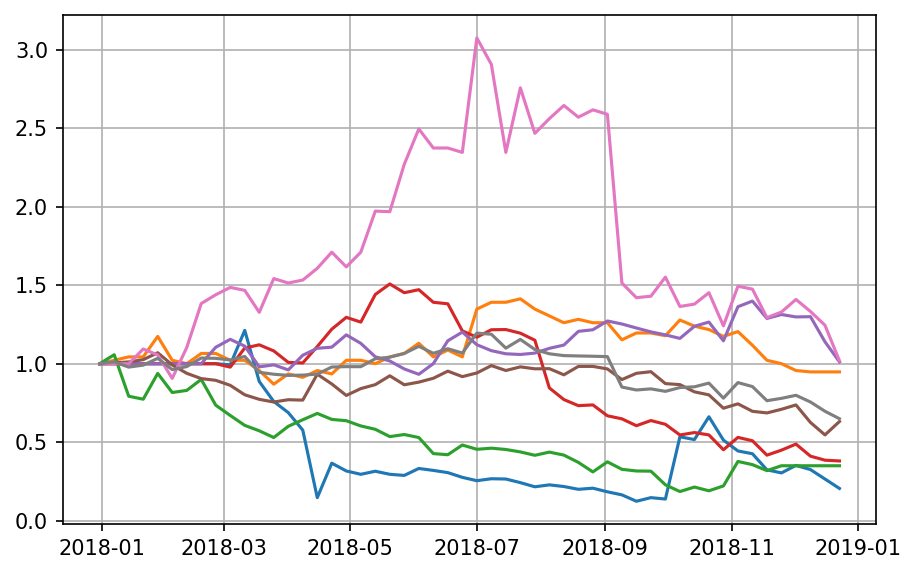

In [58]:
#make X ticks standard, and grab stock prices as close to
# those points as possible for each stock (To track performance)

#DatetimeIndex
date_range = pd.date_range(start=myDate, periods=52, freq='W') 

bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# 7 greatest performance stocks of y_pred 
ticker_list = y_small[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"].values
print(ticker_list)

stockRet = getStockTimeSeries(date_range, y_withData_Test, 
                              ticker_list, 
                              mask2015, 
                              daily_stock_prices_data)

stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

stockRetRel.head()

plt.plot(stockRetRel);
plt.grid()


# Plot backtest with S&P500

volatility of AI investor was:  1.3759320717225751
volatility of S&P 500 was:  0.325059094152396


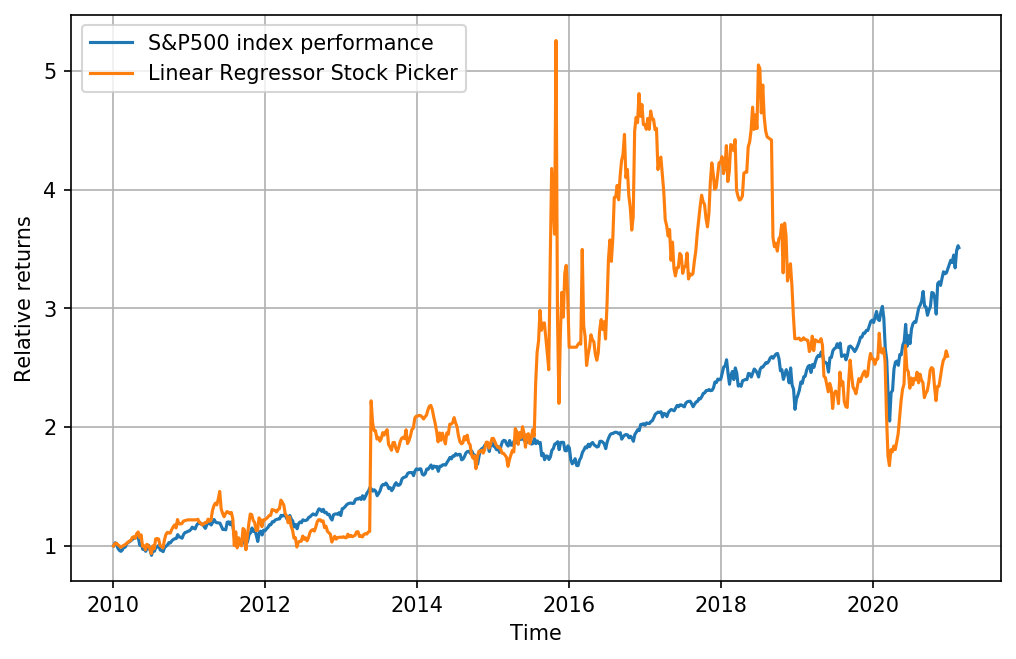

In [63]:
# GSPC.csv taken directly from Yahoo.com is the S&P500.
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=1235174400&period2=1613865600&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true
spy=pd.read_csv("GSPC.csv", index_col='Date', parse_dates=True)
spy = spy[spy.index > pd.to_datetime('2010-01-01')]
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.plot(backTest)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])
#plt.savefig('spy.png')
print('volatility of AI investor was: ', backTest['Indexed Performance'].diff().std()*np.sqrt(52))
print('volatility of S&P 500 was: ', spy["Relative"].diff().std()*np.sqrt(52))

In [64]:
spy.iloc[-1]

Open         3.921160e+03
High         3.930410e+03
Low          3.903070e+03
Close        3.906710e+03
Adj Close    3.906710e+03
Volume       2.302435e+09
Relative     3.511822e+00
Name: 2021-02-19 00:00:00, dtype: float64

In [65]:
# Top stocks picked, and predicted performance.
bl_bestStocks = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked and predicted performance is:")
print(y_small[mask2015].reset_index(drop=True)[bl_bestStocks]["Ticker"])
print(y_pred[bl_bestStocks])

print("\nActual performance was: ")
print(y_small[mask2015].reset_index(drop=True)[bl_bestStocks])

# Calc Altman Z score.
# To check if these companies were going to go bankrupt
Z = 3.25 \
+ 6.51 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['(CA-CL)/TA']\
+ 3.26 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['RE/TA']\
+ 6.72 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['EBIT/TA']\
+ 1.05 * X_test[mask2015].reset_index(drop=True)[bl_bestStocks]['Book Equity/TL']
print('\nZ scores:\n',Z)


Top predicted perf. stocks picked and predicted performance is:
44     VTVT
180     LEE
257    WNDW
269    SGMS
341     DIN
377     NAV
473    EGAN
Name: Ticker, dtype: object
            0
44   0.534452
180  0.399055
257  0.532018
269  0.405163
341  0.403704
377  0.397023
473  0.398858

Actual performance was: 
    Ticker      Perf
44    VTVT -0.599374
180    LEE -0.052174
257   WNDW -0.386965
269   SGMS -0.296420
341    DIN  0.605108
377    NAV -0.408809
473   EGAN  0.125424

Z scores:
 44     -1.691952
180     2.118304
257   -71.950523
269     3.284198
341     1.908852
377     1.155005
473   -27.662049
dtype: float64
